# layer distribution by age

# setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import glob
import os

from scipy.optimize import curve_fit

color = ['#222222', '#1b98f8']

## read matrix

from data_extraction_brdu

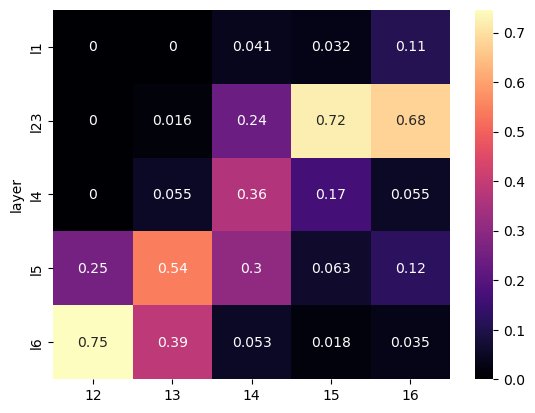

In [2]:
layer_df = pd.read_csv('supplementary/brdu_layer_matrix.csv', index_col=0)

sns.heatmap(layer_df.astype(float), annot=True, cmap="magma")
plt.show()

## plotting

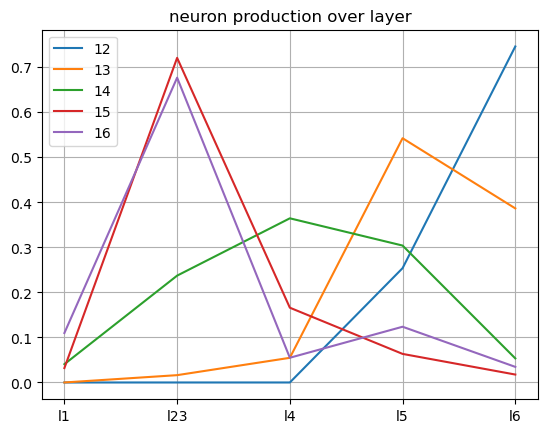

In [3]:
for col in layer_df.columns:
    plt.plot(layer_df.index, layer_df[col].values, label=col)

plt.title('neuron production over layer')
plt.legend()
plt.grid()
plt.savefig('plots/brdu_age_distribution.pdf')

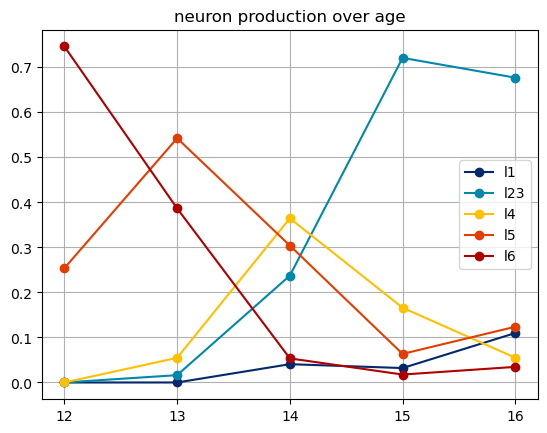

In [4]:
layer_colors = ['#ae0000', '#e33e00', '#ffc000', '#0088ab', '#03286b'][::-1]

x = np.array(layer_df.columns).astype(float).astype(int)
for (i, row), l_color in zip(layer_df.iterrows(), layer_colors):
    plt.plot(x, row.values, marker = 'o', label=i, color=l_color)

plt.legend()
plt.title('neuron production over age')
plt.xticks(np.arange(12, 16.5, 1))
plt.grid()
plt.show()

## removing l1

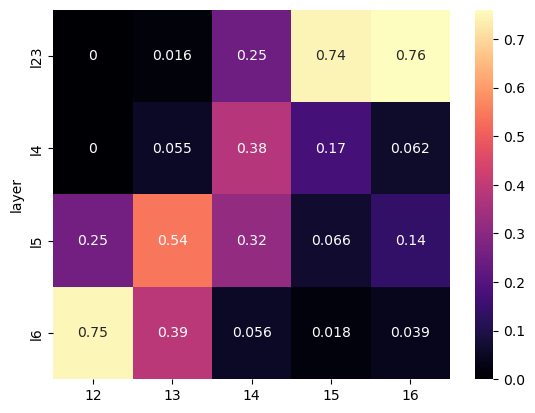

In [5]:
normalized_df = layer_df[layer_df.index != 'l1']

normalized_df = normalized_df.divide(normalized_df.sum(axis=0), axis=1)

sns.heatmap(normalized_df.astype(float), annot=True, cmap="magma")
plt.show()

# gaussian fitting

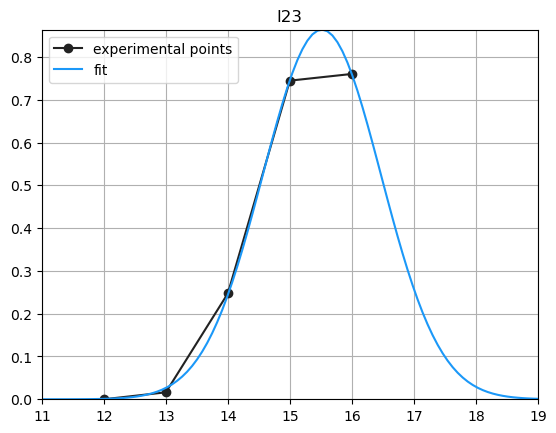

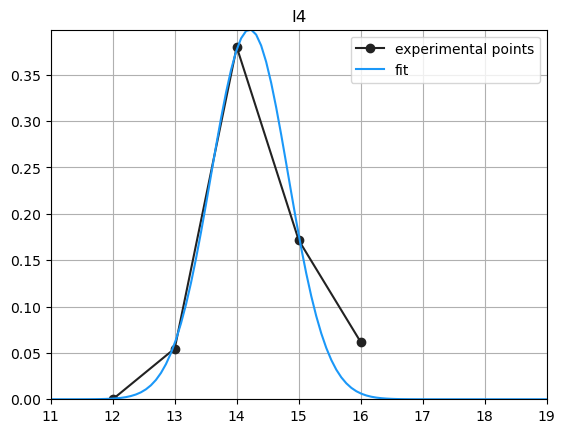

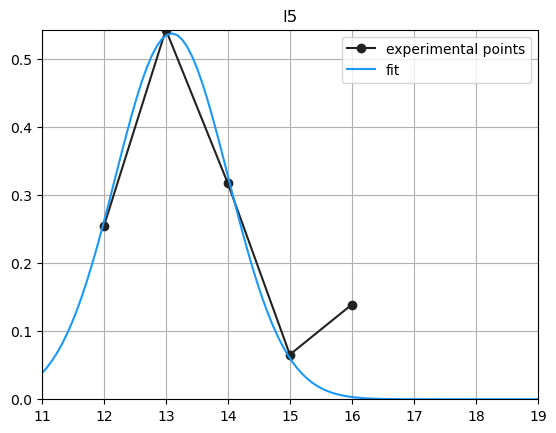

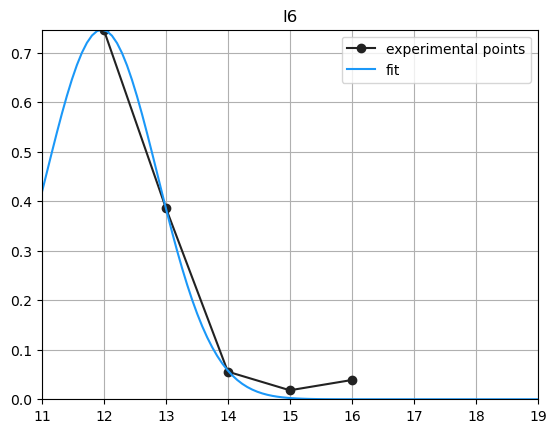

In [6]:
def gaussian(x, m, s, k):
    return k * np.exp(-((x-m)/s)**2)

def gaussian_fit(x, y, title = ''):
    max_x = x[np.argmax(y)]
    p0 = [max_x,0.5,1] # this is an mandatory initial guess

    popt, pcov = curve_fit(gaussian, x, y, p0, method='dogbox')

    # print(*popt)

    x_line = np.linspace(0, 8, 100)
    y_line = gaussian(x_line, *popt)

    y_max = max(np.max(y_line), np.max(y))


    plt.plot(x + 11, y, marker='o', color=color[0], label='experimental points')
    plt.plot(x_line + 11, y_line, linestyle='-', color=color[1], label='fit')
    plt.xlim([11, 19])
    plt.ylim([0, y_max])
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

    return {'m': popt[0], 's': popt[1], 'k': popt[2]}


x = np.array(normalized_df.columns).astype(float).astype(int) - 11

gaus_coeff = pd.DataFrame()

for i, row in normalized_df.iterrows():

    y = row.values

    try:
        output = gaussian_fit(x,y,i)
        output['l'] = i

        output_dict = pd.DataFrame([output])
        gaus_coeff = pd.concat([output_dict, gaus_coeff], ignore_index=True)
    except:
        print(f'{i} is not gaussian')

## gaussian vs experimental data

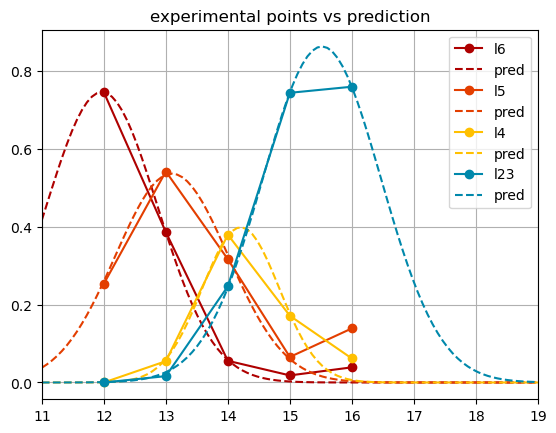

In [7]:
layer_colors = ['#ae0000', '#e33e00', '#ffc000', '#0088ab', '#03286b']

x = np.array(normalized_df.columns).astype(float).astype(int) - 11
x_line = np.linspace(0, 8, 100)

y_func = np.zeros((5, x_line.shape[0]))


for index, row in gaus_coeff.iterrows():

    # c = colors[index % len(colors)]

    # experimental points
    y = np.array(normalized_df.loc[row['l']])

    # calculated function
    y_line = gaussian(x_line, *row[:-1])
    y_func[index] = y_line

    plt.plot(x + 11, y, marker='o', color=layer_colors[index], label=row['l'])
    plt.plot(x_line + 11, y_line, linestyle='--', color=layer_colors[index], label=f'pred')

plt.xlim([11, 19])
# plt.ylim([0,0.4])
plt.grid(True)
plt.legend()
plt.title('experimental points vs prediction')
plt.show()

## layers percentages by time

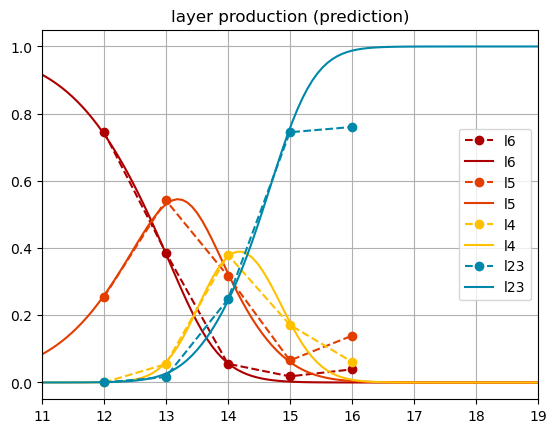

In [8]:
tot = np.sum(y_func, axis = 0)

for index, row in gaus_coeff.iterrows():

    # experimental points
    y = np.array(normalized_df.loc[row['l']])

    plt.plot(x + 11, y, marker='o', linestyle='--', color=layer_colors[index], label=row['l'])
    plt.plot(x_line + 11, y_func[index] / tot, color=layer_colors[index], label=row['l'])


plt.xlim([11, 19])
plt.ylim([-0.05,1.05])
plt.grid(True)
plt.legend()
plt.title('layer production (prediction)')
plt.savefig('results/brdu_layer_distribution.pdf')
plt.show()

In [9]:
print(gaus_coeff)
gaus_coeff.to_csv('layers_gaus_coef.csv', index=False)

          m         s         k    l
0  0.968370  1.270668  0.746668   l6
1  2.096030  1.288097  0.536845   l5
2  3.208169  0.879716  0.398943   l4
3  4.517119  1.349107  0.863851  l23
